# Welcome to your third assignment!

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry. We need you to upload the .ipynb-file and the exported .pdf of this notebook.

If you have any questions, ask them in either in the tutorials or in the "Mattermost" channel: https://mattermost.imp.fu-berlin.de/biorobotics/channels/ssl_ws_2324


In this assignment, we want you to explore Autoencoders.

# Slide Review

[Google Form](https://forms.gle/ZgL1p9g1T9GgtAkVA) for the slide review. Please take a minute to scroll over the slides again and improve your lecture.

Please make sure to only choose your top 5 slides per lecture!

# PapagAI

From the second week onwards we started the reflective study.
Register on the [PapagAI website](https://www.papag.ai) and write your first reflection about your impressions and challenges in the context of the lectures and tutorials you had this and previous week. The size of reflection can be anywhere bigger than 100 words. You can check out this [YouTube video](https://www.youtube.com/watch?v=QdmZHocZQBk&ab_channel=FernandoRamosL%C3%B3pez) with instructions on how to register, create a reflection and get an ai feedback.

Please note, that this task is an obligatory one for this course and make sure each of you does the reflection, not only one person per group.

#### Please state both names of your group members here:
Authors: Omar Ahmed and Can Aydin


# Assignment 3: Autoencoder

This week's lecture introduced Autoencoders (AE), Denoising Autoencoders (DAE), and Masked Autoencoders (MAE). We want you to implement solutions for each approach in the following exercises. They will all use the MNIST images dataset, like the previous assignments. Here are the paper-links for you to read up on them:

AE - [Paper](https://www.cs.toronto.edu/~hinton/absps/science.pdf) <br>
DAE - [Paper](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf) <br>
MAE - [Paper](https://arxiv.org/pdf/2111.06377.pdf) <br>


## Ex. 3.1 Autoencoder for Compression

Build an Autoencoder with a compressed latent space. You should use Convolution for downscaling and Deconvolution for upscaling. **(RESULT)**

Train your model on MNIST images and compare at least 5 original and reconstructed images visually. **(RESULT)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(42)


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size

train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 29364405.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41843072.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54392451.29it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 600205.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [20]:
from torch.nn.modules.conv import ConvTranspose2d

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()
    self.encoder = nn.Sequential(
      #Encoder
      nn.Conv2d(1,16, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2) # 32 x 32 x 7 x 7
    )
    self.decoder = nn.Sequential(
      #Decoder
      nn.ConvTranspose2d(32,16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16,1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
      nn.Sigmoid()
    )
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [21]:
model_autoencoder = Autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_autoencoder.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for data in train_loader:
    image, _ = data
    output = model_autoencoder(image)
    loss = loss_function(output, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.9270
Epoch [2/10], Loss: 0.9270
Epoch [3/10], Loss: 0.9270
Epoch [4/10], Loss: 0.8989
Epoch [5/10], Loss: 0.8982
Epoch [6/10], Loss: 0.8979
Epoch [7/10], Loss: 0.8924
Epoch [8/10], Loss: 0.8868
Epoch [9/10], Loss: 0.8863
Epoch [10/10], Loss: 0.8861


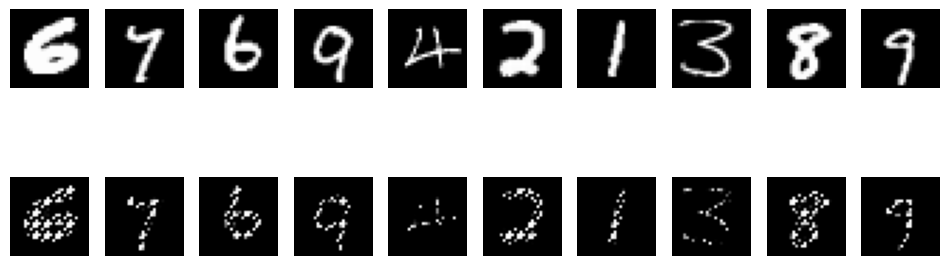

In [22]:
def visualize_images(model, data_loader, num_images = 10):

  data = iter(data_loader)
  image, _ = next(data)
  output = model(image)

  fig, axs = plt.subplots(2, 10, figsize=(12, 4))
  for i in range(num_images):
      axs[0, i].imshow(image[i][0].numpy(), cmap='gray')
      axs[0, i].axis('off')
      axs[1, i].imshow(output[i][0].detach().numpy(), cmap='gray')
      axs[1, i].axis('off')

  plt.show()
visualize_images(model_autoencoder,train_loader)

## Ex. 3.2 Denoising AE

As a second exercise, we want you to build a denoising autoencoder (DAE). The DAE may have more latent dimensions than input dimensions. The training on noisy inputs prevents it from learning the identity function. Therefore, using a bigger latent space is possible, too. Make sure to use the original inputs for computing the loss.

- Build a DAE with more hidden dimensions than input dimensions. **(RESULT)** Usually a higher channel count provides a bigger latent space, while the spatial dimentsion are reduced.

- Train it on MNIST samples that have two different flavours of noise applied to them. Show at least 5 denoised samples with your model and compare them visually to the respective input  **(RESULT)**

- Compare two different loss functions and their effect on the model's reconstruction performance. **(RESULT)**

In [4]:

class GaussianNoise(object):
    def __init__(self, mean=0., std=0.3):
      self.std = std
      self.mean = mean

    def __call__(self, tensor):
      return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
      return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class SaltAndPepperNoise(object):
    def __init__(self, probability = 0.005):
      self.probability = probability

    def __call__(self, tensor):
        # Generate the salt and pepper noise based on the probability
      mask_salt = torch.rand(tensor.size()) < self.probability / 2
      mask_pepper = torch.rand(tensor.size()) < self.probability / 2

      tensor[mask_salt] = 1  # salt noise
      tensor[mask_pepper] = 0  # pepper noise
      return tensor

    def __repr__(self):
      return self.__class__.__name__ + '(probability={0})'.format(self.probability)

In [5]:
class CombinedNoise(object):
    def __init__(self, mean=0., std=0.5, probability=0.01):
        self.gaussian_noise = GaussianNoise(mean, std)
        self.salt_and_pepper_noise = SaltAndPepperNoise(probability)

    def __call__(self, tensor):
        tensor = self.gaussian_noise(tensor)
        tensor = self.salt_and_pepper_noise(tensor)
        return tensor

In [6]:
def apply_noise_to_dataset(dataset, transform):
    noisy_dataset = []
    for image, label in dataset:
        noisy_image = transform(image)
        noisy_dataset.append((noisy_image, label))
    return noisy_dataset

In [7]:
torch.manual_seed(42)
transform_combined_noise = CombinedNoise(mean = 0, std = 0.5, probability = 0.01)

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

train_dataset_noisy = apply_noise_to_dataset(train_dataset, transform_combined_noise)
test_dataset_noisy = apply_noise_to_dataset(test_dataset, transform_combined_noise)

batch_size = 32

train_noisy_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=False)
test_noisy_loader = DataLoader(test_dataset_noisy, batch_size=batch_size, shuffle=False)

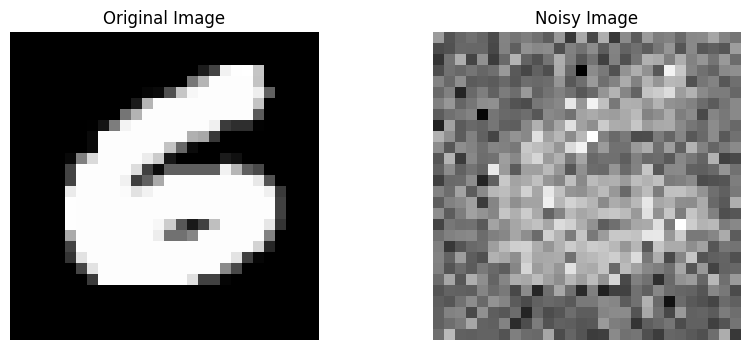

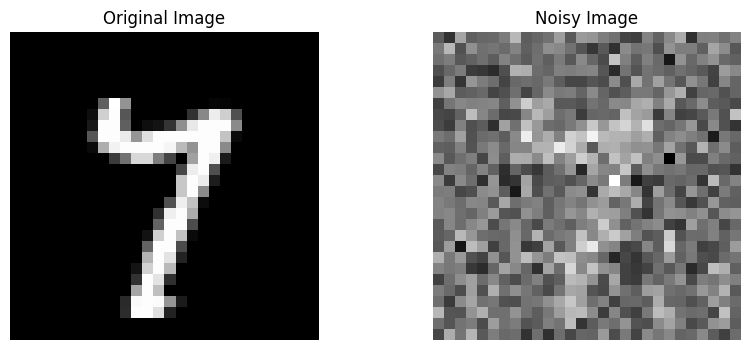

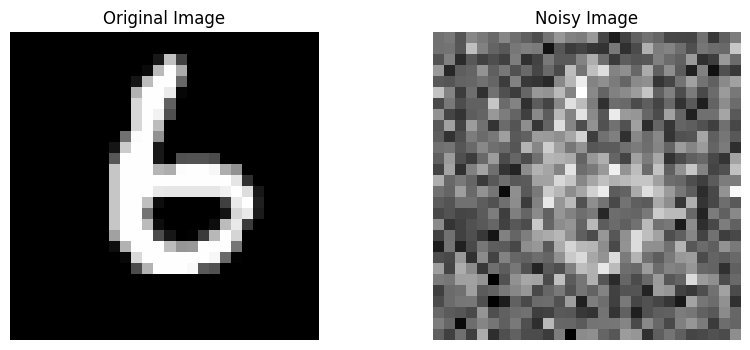

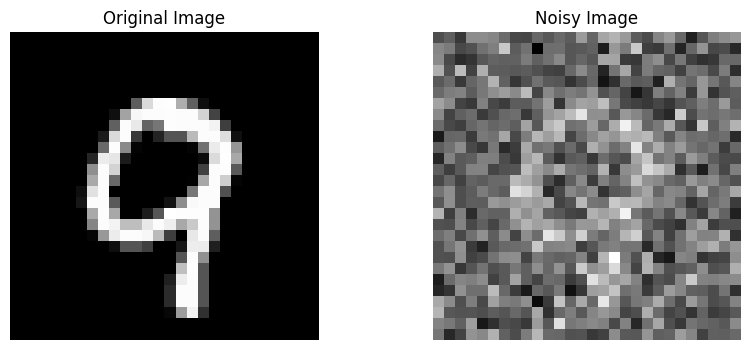

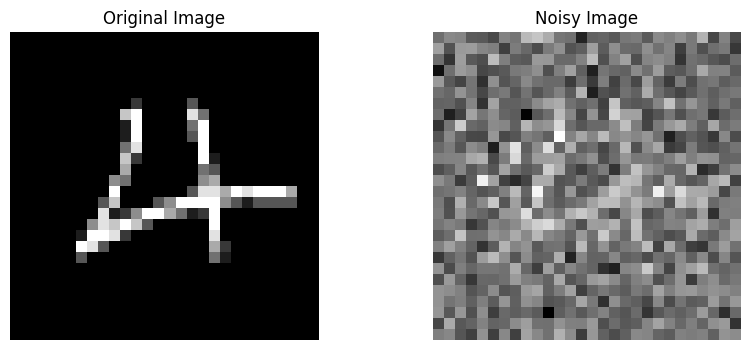

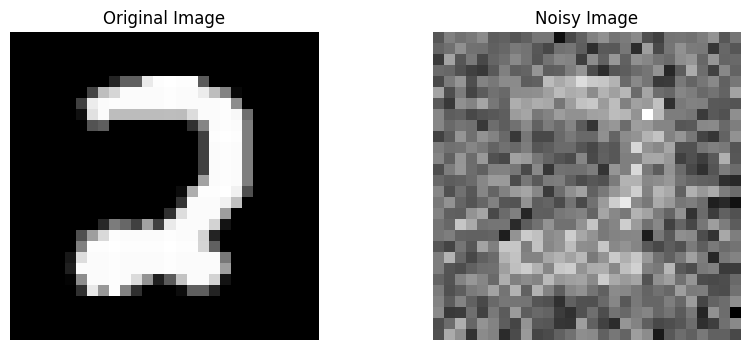

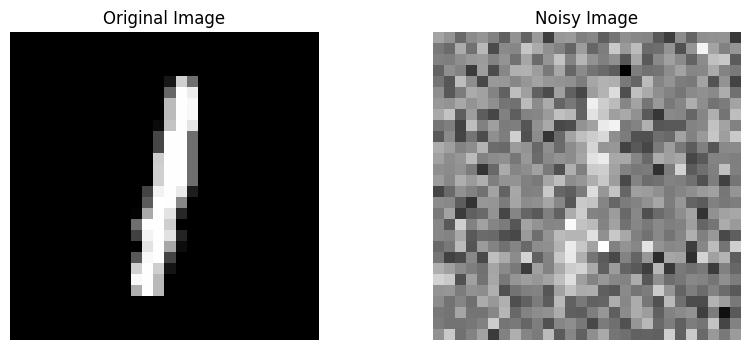

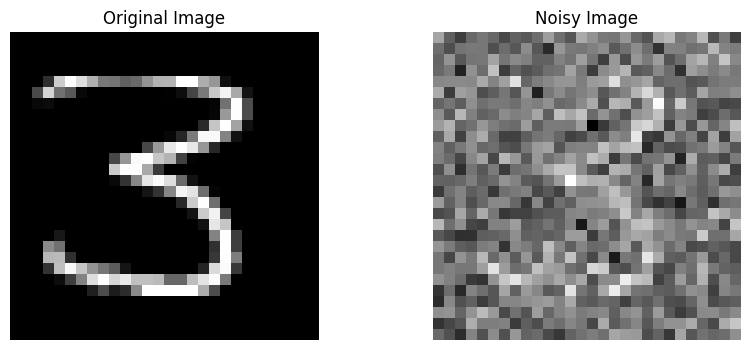

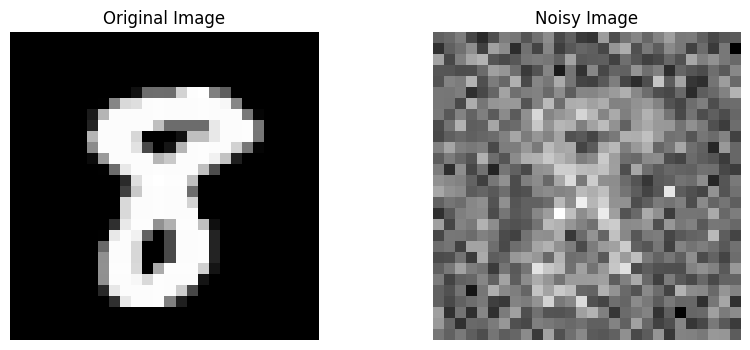

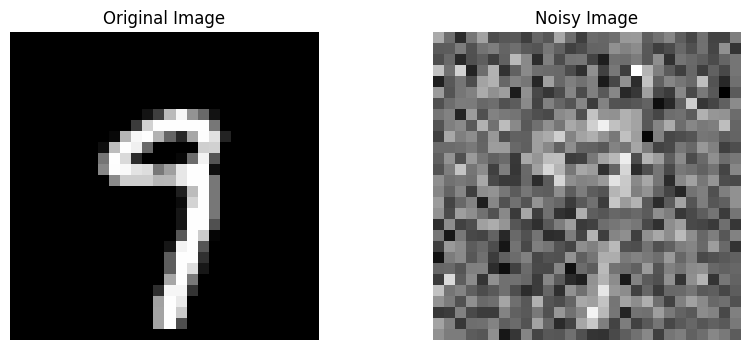

In [8]:
def visualize_images_side_by_side(original_image, noisy_image, title1="Original Image", title2="Noisy Image"):
    plt.figure(figsize=(10, 4))

    # Visualize original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.numpy().squeeze(), cmap='gray')
    plt.title(title1)
    plt.axis('off')

    # Visualize noisy image
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image.numpy().squeeze(), cmap='gray')
    plt.title(title2)
    plt.axis('off')

    plt.show()

# Get one batch from each DataLoader
original_images, _ = next(iter(train_loader))
noisy_images, _ = next(iter(train_noisy_loader))
img = 10
# Visualize the first image from each batch
for i in range(img):
  visualize_images_side_by_side(original_images[i], noisy_images[i])

In [13]:
class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoencoder,self).__init__()
    self.encoder = nn.Sequential(
      #Encoder
      nn.Conv2d(1,32, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2) #32 x 128 x 3 x 3
    )
    self.decoder = nn.Sequential(
      #Decoder
      nn.ConvTranspose2d(128,64, kernel_size = 2, stride = 2, padding = 0, output_padding = 1), # 32 x 64 x 7 x 7
      nn.ReLU(),
      nn.ConvTranspose2d(64,32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), # 32 x 32 x 14 x 14
      nn.ReLU(),
      nn.ConvTranspose2d(32,1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), # 32 x 1 x 28 x 28
      nn.Sigmoid()
    )
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [14]:
len(train_noisy_loader)

1500

In [15]:
model = DenoisingAutoencoder()
loss_function_1 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 5

for epoch in range(epochs):
  for data in train_noisy_loader:
    image, _ = data
    output = model(image)
    loss = loss_function_1(output, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Loss Function: {loss_function_1}')


Epoch [1/5], Loss: 0.2469, Loss Function: MSELoss()
Epoch [2/5], Loss: 0.2400, Loss Function: MSELoss()
Epoch [3/5], Loss: 0.2335, Loss Function: MSELoss()
Epoch [4/5], Loss: 0.2293, Loss Function: MSELoss()
Epoch [5/5], Loss: 0.2249, Loss Function: MSELoss()


In [16]:
model.eval()

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

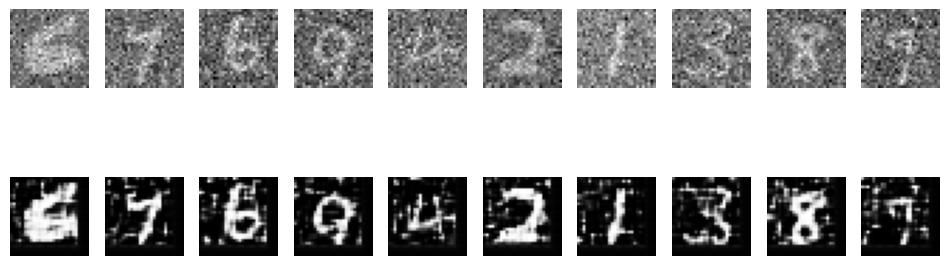

In [24]:
visualize_images(model,train_noisy_loader)

In [75]:
model_2 = DenoisingAutoencoder()
loss_function_2 = nn.L1Loss()
optimizer = optim.Adam(model_2.parameters(), lr = 0.001)

epochs = 5

for epoch in range(epochs):
  for data in train_noisy_loader:
    image, _ = data
    output = model(image)
    loss = loss_function_2(output, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Loss Function: {loss_function_2}')


Epoch [1/5], Loss: 0.3612, Loss Function: L1Loss()
Epoch [2/5], Loss: 0.3612, Loss Function: L1Loss()
Epoch [3/5], Loss: 0.3612, Loss Function: L1Loss()
Epoch [4/5], Loss: 0.3612, Loss Function: L1Loss()
Epoch [5/5], Loss: 0.3612, Loss Function: L1Loss()


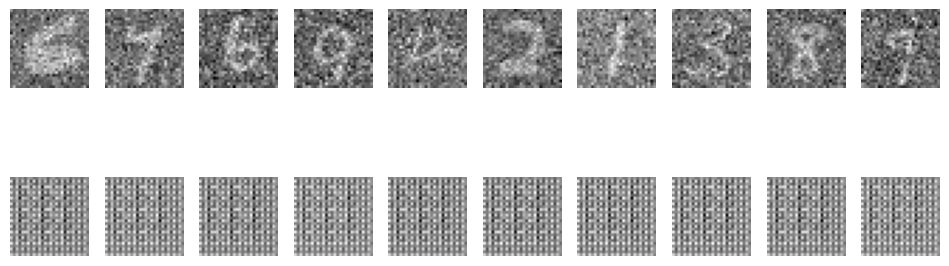

In [76]:
visualize_images(model_2,train_noisy_loader)

##So MSE works well, while L1Loss performs horribly.


## Ex. 3.3 Masked AE (BONUS)

Implement a Masked Autoencoder (MAE) model for image data, i.e. the MNIST data. Can you build representations using fully connected or convolutional layers? You don't have to implement a Transformer as an Encoder or Decoder for this exercise. **(RESULT)**

Make sure to utilize image-patching. The masking token can be fixed and does not have to be learnable by the Decoder.

Check the performance of your Autoencoder on a the finetuning classification task on the MNIST test dataset. Report on the accuracy using your learned representations. **(RESULT)**

Bonus question: What can you do to account for information leekage in the MAE that uses Convolutional Layers?

##Roadmap
1. Divide images in patches
2. mask 75% - 80% of the image
3. Pass the unmasked to the encoder
4. Add the masked patches
5. Pass it to the decoer with positional embedding
6. Decoder produces predictions for all image patches
7. Let the decoder know which patches you mask (easy)
8. Tip: Unfold

In [44]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

one_image = images
print(one_image.shape)
# Nice to remind myself that the images have 32x1x28x28 dimensions.
# 32 - Batch, 1 - Grayscale, 28 x 28 - Hegith x Width

torch.Size([32, 1, 28, 28])


In [67]:
#We implement a function to create patches
""" We are sclicing across 2nd dim (HEIGHT),
     then across 3rd dim (WIDTH) To get non-overlapping patches"""
# We created 16 batches, each 7x7 in dimension

def create_patches(images):
    batch_size, channels, height, width = images.shape
    patches = images.unfold(2, 7, 7).unfold(3, 7, 7)
    patches = patches.contiguous().view(batch_size, -1, channels, 7, 7)
    return patches

# We implement a function to mask.
def masking(patches, masked_percentage = 0.5):
  batch_size, num_patches, channels, patch_size, _ = patches.shape
  num_masked = int(num_patches * masked_percentage)

  masked_indices = torch.from_numpy(np.random.choice(num_patches, num_masked, replace=False))

  mask = torch.ones((batch_size, num_patches, 1, 1, 1), dtype=torch.float32)
  for i in masked_indices:
    mask[:, masked_indices, :, :, :] = 0

  unmasked_patches = patches.clone() * mask
  masked_patches = patches.clone() * (1-mask)

  masked_patches = patches * mask
  return unmasked_patches, masked_patches, mask

def masked_and_encoded(encoded_patches, masked_patches, mask):
  combined_patches = torch.cat([encoded_patches,masked_patches],dim=1)
  return combined_patches


##Passing the unmasked images to the encoder

In [77]:
class MaskedAutoencoder(nn.Module):
  def __init__(self):
    super(MaskedAutoencoder,self).__init__()
    self.encoder = nn.Sequential(
      #Encoder (Takes in non-encoded patches)
      nn.Conv2d(1,32, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2) #32 x 128 x 3 x 3
    )
    self.decoder = nn.Sequential(
      #Decoder (Takes in encoded pathces and masking)
      nn.ConvTranspose2d(128,64, kernel_size = 2, stride = 2, padding = 0, output_padding = 1), # 32 x 64 x 7 x 7
      nn.ReLU(),
      nn.ConvTranspose2d(64,32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), # 32 x 32 x 14 x 14
      nn.ReLU(),
      nn.ConvTranspose2d(32,1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), # 32 x 1 x 28 x 28
      nn.Sigmoid()
    )
  def forward(self,unmasked_patches, masked_patches, mask):
    encoded_patches = self.encoder(unmasked_patches)
    decoder = masked_and_encoded(encoded_patches, masked_patches,mask)
    x = self.decoder(x)
    return x

In [80]:
model_mae = MaskedAutoencoder()
loss_function_1 = nn.MSELoss()
optimizer = optim.Adam(model_mae.parameters(), lr = 0.001)

epochs = 5
model_mae.train()

for epoch in range(epochs):
  for data in train_loader:
    image, _ = data
    patches = create_patches(image)
    unmasked_patches, masked_patches, mask = masking(patches)
    output = model_mae(unmasked_patches, masked_patches, mask)
    loss = loss_function_1(output, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Loss Function: {loss_function_1}')


RuntimeError: ignored